In [82]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
sns.set()

import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions import Normal

## Neural Processes++

### Easy case: 1d

We define a function parametrized by neural network:

$$f_\theta : x \rightarrow h$$

We define the parameters $\alpha$ and $\beta$ defined by the following distribution

$$p(\alpha | \mu_\alpha, \sigma_\alpha) = \mathcal{N}(\mu_\alpha, \sigma_\alpha^2)$$
$$p(\beta | \mu_\beta, \sigma_\beta) = \mathcal{N}(\mu_\beta, \sigma_\beta^2)$$

We define the observation model as:

$$ y \sim \mathcal{N} \Big(\mu_\alpha f_\theta(x) + \mu_\beta,(\sigma_\alpha f_\theta(x))^2 + \sigma_\beta^2  \Big)$$



Given $\mu = \mu_\alpha f_\theta(x) + \mu_\beta $ and $\sigma = \sqrt{(\sigma_\alpha f_\theta(x))^2 + \sigma_\beta^2 }$, $K$ being a constant, the likelihood is then defined by:

\begin{equation}
\begin{split}
\log p(\mu_\alpha, \sigma_\alpha,\mu_\beta, \sigma_\beta | y ) &= -\frac{1}{2} \big[ \log \sigma^2 + \frac{(y - \mu)^2}{\sigma^2} \big] + K
\end{split}
\end{equation}

#### Toy Dataset 1

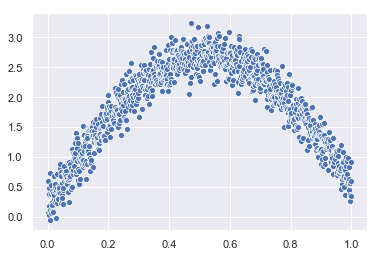

In [121]:
N = 1000
a = 0.5
b = 0.2
scale = 0.2
x = np.linspace(0,1,N)
f = lambda x_ : 5*np.sin(3*x_)
gen_y = lambda x_i : a * f(x_i) + b + scale * np.random.normal()
y = [gen_y(x_i) for x_i in x]
sns.scatterplot(x,y)
plt.show()

#### Implement posterior loglikelihood

In [125]:
prior_alpha = Normal(0,1)
prior_beta = Normal(0,1)
mu = lambda h, mu_a, mu_b : mu_a * h + mu_b
sigma2 = lambda h, sigma_a, sigma_b: (sigma_a * h)**2 + sigma_b**2
log_ll = lambda y, mu, sigma_2 : -0.5 * ( torch.log(sigma_2) + (y - mu)**2 / sigma_2)
log_p = lambda y, mu, sigma_2 : log_ll(y, mu, sigma_2) + prior_alpha.log_prob(y) + prior_beta.log_prob(y)

#### Features Extractor, Prior parameters and loss function

In [136]:
class FeaturesExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential( nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 1) )
    def forward(self, x):
        
        return self.layers(x[:,None]).squeeze()
    
class Priors(nn.Module):
    def __init__(self):
        super().__init__()
        self.mu_a = nn.Parameter(torch.tensor(0.))
        self.mu_b = nn.Parameter(torch.tensor(0.))
        self.sigma_a = nn.Parameter(torch.tensor(1.))
        self.sigma_b = nn.Parameter(torch.tensor(1.))
        
        
def criterion(h, y, priors):
    mu_ = mu(h, priors.mu_a, priors.mu_b)
    sigma2_ = sigma2(h, priors.sigma_a, priors.sigma_b)
    return - log_posterior(y, mu_, sigma2_)

#### Optimize

In [137]:
features = FeaturesExtractor()
priors = Priors()
l_rate = 0.01
epochs = 1000
optimiser = torch.optim.Adam(list(features.parameters()) + list(priors.parameters()), lr = l_rate) 
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

for epoch in range(epochs):
    epoch +=1
    optimiser.zero_grad()
    h = features.forward(x)
    loss = criterion(h, y, priors)
    loss = loss.mean()
    loss.backward()# back props
    optimiser.step()# update the parameters
    if epoch % 200 == 0:
        print('epoch {}, loss {}'.format(epoch,loss))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


epoch 200, loss 4.738431930541992
epoch 400, loss 4.736564636230469
epoch 600, loss 4.7353997230529785
epoch 800, loss 4.735051155090332
epoch 1000, loss 4.735019207000732


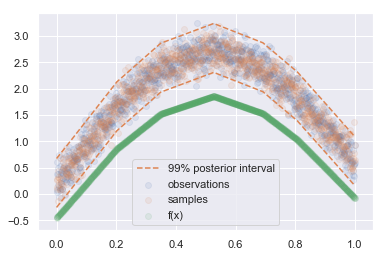

In [138]:
h = features(x)
mu_ = mu(h, priors.mu_a, priors.mu_b)
sigma2_ = sigma2(h, priors.sigma_a, priors.sigma_b)
p5 = Normal(mu_, sigma2_.sqrt()).icdf(0.01 * torch.ones_like(mu_)).detach()
p95 = Normal(mu_, sigma2_.sqrt()).icdf(0.99 * torch.ones_like(mu_)).detach()
samples = Normal(mu_, sigma2_.sqrt()).sample()
plt.scatter(x,y, alpha=0.1, label='observations')
plt.scatter(x,samples.numpy(), alpha=0.1, label='samples')
plt.scatter(x,h.detach().numpy(), alpha=0.1, label='f(x)')
plt.plot(x.numpy(), p5.numpy(), '--', color=sns.color_palette()[1], label='99% posterior interval')
plt.plot(x.numpy(), p95.numpy(), '--',color=sns.color_palette()[1])
plt.legend()
plt.show()